In [1]:
# Import Libraries
%tensorflow_version 1.x
import cv2
import os
from glob import glob

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential, load_model #for neural network models
from keras.layers import Input, Dense, Flatten,Conv2D, ZeroPadding2D, MaxPooling2D, Dropout
from keras.layers import Conv2DTranspose, SeparableConv2D, BatchNormalization, Reshape # Import hidden layer
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.optimizers import Adam #For Optimizing the Neural Network
from keras.applications.vgg16 import VGG16 # VGG16 saved model from keras
from keras import layers
from keras.layers import Input
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#Hyperparameters
img_width = 160  
img_height = 160
img_channel = 3
input_shape = (img_height,img_width,img_channel)
num_epochs = 50
batch_size = 32
latent_dim = 128

In [3]:
#Encoding  - mapping image inputs to latent distribution parameters


encoder_inputs = Input(shape=(input_shape)) 

x = Conv2D(64, (3,3), activation='relu', padding='same')(encoder_inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), name='pool1')(x)

x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2,2), name='pool2')(x)

x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2,2), name='pool3')(x)
    
x = SeparableConv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2,2), name='pool4')(x)

before_faltten_shape = K.int_shape(x)
x = Flatten()(x)

#bottle neck layer
latent = Dense(latent_dim, activation='relu', name='latent_layer')(x)

encoder = Model(inputs = encoder_inputs, outputs = latent, name='encoder')
encoder.summary()















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 160, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 80, 80, 64)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 80, 80, 128)       8896      
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 80, 128)       512      

In [4]:
decoder_inputs = Input(shape=(latent_dim,), name='latent_inputs')

# decoder

#Reshape

x = Dense(before_faltten_shape[1]*before_faltten_shape[2]*before_faltten_shape[3], activation='relu')(decoder_inputs)
x = Reshape((before_faltten_shape[1],before_faltten_shape[2],before_faltten_shape[3]))(x)


#Decoder part
x = Conv2DTranspose(512, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = BatchNormalization(name='bn5')(x)
x = Conv2DTranspose(256, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = BatchNormalization(name='bn6')(x)
x = Conv2DTranspose(128, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = BatchNormalization(name='bn7')(x)
x = Conv2DTranspose(64, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = BatchNormalization(name='bn8')(x)
decoded = Conv2D(img_channel,(3,3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_inputs,decoded, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 51200)             6604800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 10, 512)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 512)       1049088   
_________________________________________________________________
bn5 (BatchNormalization)     (None, 20, 20, 512)       2048      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 40, 40, 256)       524544    
_________________________________________________________________
bn6 (BatchNormalization)     (None, 40, 40, 256)       1024

In [0]:
final_outputs = decoder([encoder(encoder_inputs)])
autoencoder = Model(encoder_inputs, final_outputs , name = 'autoencoder')

In [7]:
autoencoder.compile(optimizer ='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
encoder (Model)              (None, 128)               6736320   
_________________________________________________________________
decoder (Model)              (None, 160, 160, 3)       8348035   
Total params: 15,084,355
Trainable params: 15,080,515
Non-trainable params: 3,840
_________________________________________________________________


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd /content/drive/My Drive/DeepLearning/Project/dataset1

!ls

/content/drive/My Drive/DeepLearning/Project/dataset1
'autoencoder model'   empty   modelAlexNet_7.h5   train1
 blurred	      good    test		  val
 blurred-4	      good2   train		  VGG16_model1.h5


In [0]:
#use your dir for the data
good_path = "/content/drive/My Drive/DeepLearning/Project/dataset1/good2/"
blurred_path = "/content/drive/My Drive/DeepLearning/Project/dataset1/blurred-4/"
# ori_path = "/content/drive/My Drive/AI project/dataset/ori_blurred/"

In [0]:
noise_datagen = ImageDataGenerator(rescale=1./225,validation_split=0.25,dtype='float32')
img_datagen = ImageDataGenerator(rescale=1. / 255,validation_split=0.25, dtype='float32')
# ori_datagen = ImageDataGenerator(rescale=1. / 255, dtype='float32')

In [15]:
train_good = img_datagen.flow_from_directory(good_path,
                                             target_size=(img_width,img_height),
                                             class_mode=None,
                                             color_mode= 'rgb',
                                             batch_size=batch_size,subset='training')
test_good = img_datagen.flow_from_directory(good_path,
                                            target_size=(img_width,img_height),
                                            class_mode=None,
                                            color_mode= 'rgb',
                                            batch_size=batch_size,subset='validation')
train_blurred = noise_datagen.flow_from_directory(blurred_path,
                                                  target_size=(img_width,img_height),
                                                  class_mode=None,
                                                  color_mode= 'rgb',
                                                  batch_size=batch_size,subset='training')
test_blurred = noise_datagen.flow_from_directory(blurred_path,
                                                 target_size=(img_width,img_height),
                                                 class_mode=None,
                                                 color_mode= 'rgb',
                                                 batch_size=batch_size,subset='validation')
# ori_blurred = ori_datagen.flow_from_directory(ori_path,
#                                               target_size=(img_width,img_height),
#                                               class_mode=None,
#                                               color_mode = 'rgb',
#                                               batch_size=batch_size)

Found 1523 images belonging to 1 classes.
Found 507 images belonging to 1 classes.
Found 1523 images belonging to 1 classes.
Found 507 images belonging to 1 classes.


In [16]:
#shape check
train_good.image_shape

(160, 160, 3)

In [0]:
# create generators using zip() that will train orginal and noisy images 
train_generator = zip(train_blurred, train_good)
test_generator = zip(test_blurred,test_good)

In [0]:
class NEpochPrint(Callback):
    def __init__(self, display_step):
        self.epoch = 0
        self.display_step = display_step
    def on_epoch_end(self,epoch,logs={}):
        self.epoch += 1        
        if self.epoch == 1 or self.epoch % self.display_step == 0:
            print('Epoch: {}/{} ..... {}: {:.4f} - {}: {:.4f}'.format(self.epoch,
                                                                      self.params['epochs'],
                                                                      self.params['metrics'][0], 
                                                                      logs.get(self.params['metrics'][0]),
                                                                      self.params['metrics'][1],               
                                                                      logs.get(self.params['metrics'][1])))
NEpochPrinter = NEpochPrint(display_step=2)

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,factor=0.5,min_lr=0.00001)
saving_folder = 'best_weight_autoencoder_v3'
file_name = 'autoencoder_v3'
os.makedirs(saving_folder,exist_ok=True)
best_model_weight_path = os.path.join(saving_folder,file_name+'-best-wiehgts'+'-{epoch:03d}-{loss:.3f}-{val_loss:.3f}.h5')
save_best_model = ModelCheckpoint(best_model_weight_path,monitor='val_loss',verbose=0,save_weights_only=True,save_best_only=True,mode='min')

hist = autoencoder.fit_generator(train_generator,steps_per_epoch=3046//batch_size,
                                      epochs=num_epochs,
                                      validation_data=test_generator,
                                      verbose=0,
                                      validation_steps=1014//batch_size,
                                      shuffle=False,
                                    
                                      callbacks=[save_best_model,learning_rate_reduction,NEpochPrinter]
                                      )



Epoch: 1/50 ..... loss: 0.3486 - acc: 0.3935
Epoch: 2/50 ..... loss: 0.0983 - acc: 0.4152
Epoch: 4/50 ..... loss: 0.0959 - acc: 0.4138
Epoch: 6/50 ..... loss: 0.0956 - acc: 0.4149
Epoch: 8/50 ..... loss: 0.0957 - acc: 0.4140
Epoch: 10/50 ..... loss: 0.0957 - acc: 0.4154
Epoch: 12/50 ..... loss: 0.0953 - acc: 0.4148
Epoch: 14/50 ..... loss: 0.0959 - acc: 0.4159
Epoch: 16/50 ..... loss: 0.0956 - acc: 0.4129

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch: 18/50 ..... loss: 0.0958 - acc: 0.4127
Epoch: 20/50 ..... loss: 0.0963 - acc: 0.4137
Epoch: 22/50 ..... loss: 0.0963 - acc: 0.4157

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch: 24/50 ..... loss: 0.0955 - acc: 0.4161
Epoch: 26/50 ..... loss: 0.0956 - acc: 0.4146

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch: 28/50 ..... loss: 0.0953 - acc: 0.4137
Epoch: 30/50 ..... loss: 0.0954 - acc: 0.4151
Epoch: 32/50 ..... loss:

In [0]:
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
    plt.plot(loss[0],color='b',label='training')
    plt.plot(loss[1],color='r',label='valid')
    plt.title(model_name,fontsize=18)
    plt.legend(loc='best',fontsize=13)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('loss',fontsize=15)
    plt.tick_params(axis='both',labelsize=13)

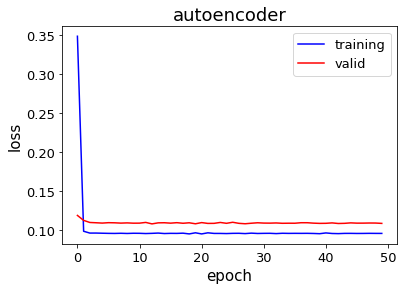

In [22]:
training_plot(hist,'autoencoder')

In [23]:
recon_img = autoencoder.predict_generator(test_blurred, steps=test_blurred.samples, verbose=1)

507/507 [==============================] - 171s 337ms/step


In [0]:
ori_img = test_blurred.next()


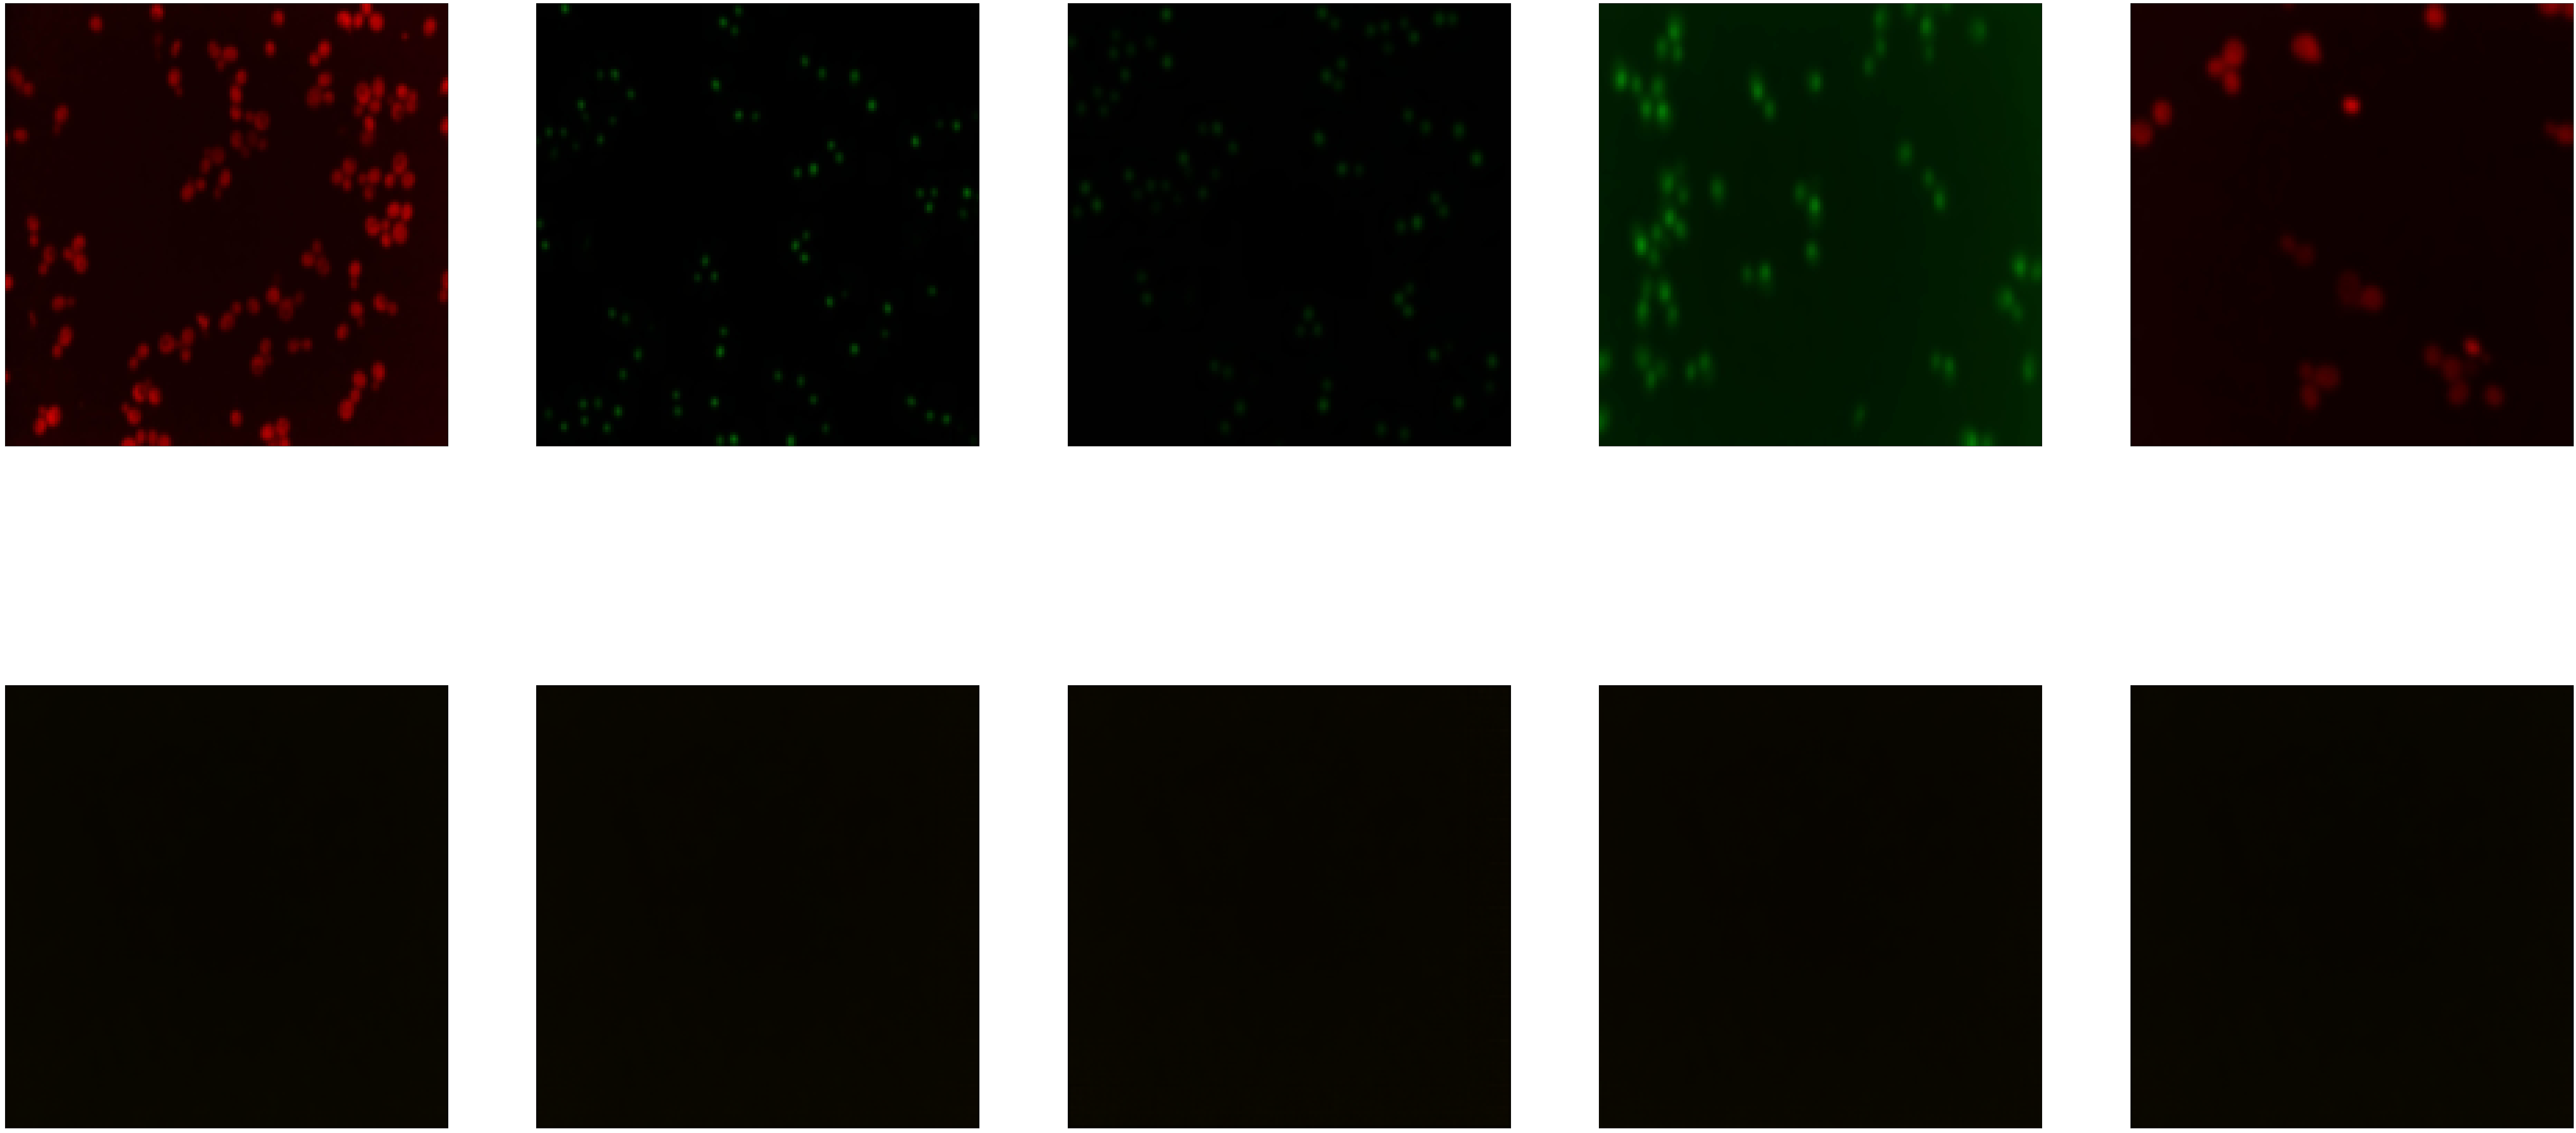

In [25]:
n = 5# # of images will display
plt.figure(figsize=(100, 50))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(ori_img[i].reshape(input_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_img[i].reshape(input_shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
def plot_five_reconstruction(input_set,random_idx,encoder,decoder):
    fig, axes = plt.subplots(2,5,figsize=(15,5))
    for row,flag in zip(axes,['in_img','out_img']): 
        for col,idx in zip(row,random_idx):
            original = input_set[idx]
            if flag == 'in_img':
                original_img = original.reshape(input_shape)
                col.imshow(original_img)
                col.set_title('original, idx={}'.format(idx))
            if flag == 'out_img':
                encoded_z = encoder.predict(np.expand_dims(original,0),batch_size=1)#[1]
                predict = decoder.predict(encoded_z)
                decoded_img = predict.reshape(input_shape)
                col.imshow(decoded_img)
                col.set_title('reconstructed, idx={}'.format(idx))
                           
            col.axis('off')

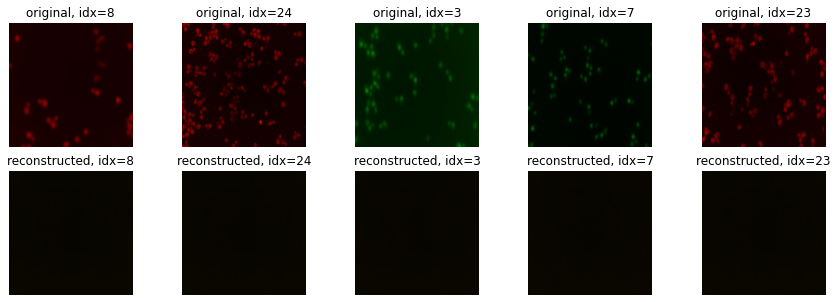

In [37]:
np.random.seed(100)
random_idx = np.random.randint(len(ori_img), size=5)
plot_five_reconstruction(ori_img,random_idx,encoder,decoder)